In [1]:
import pandas as pd
from github import Github
import matplotlib.pyplot as plt
import numpy as np
import tweepy
import sqlite3
from sqlite3 import Error
import spotipy
import sys
import pprint
%matplotlib inline

In [5]:
CONSUMER_KEY =  "Mj1lQyXBFFrHQfp7X9lBuk591"
CONSUMER_SECRET = "ihKCQfdRlnUVPIwV0LGXgGLKzAhApP9ncQEliOjXSuNxTvPVZ2"
OAUTH_TOKEN = "986964512950620161-HGKRMd49dpLL5puTbaWyvfz1HGWTo1k"
OAUTH_TOKEN_SECRET = "zBATxJeAYFZduk8FvawsDzUBG6RtZK3iiROmSPeTEFe9B"

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth)

In [6]:
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn

In [7]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [8]:

database = r"D:\apiAssgnment.db"
 
sql_create_user_table = """ CREATE TABLE IF NOT EXISTS user_twitter (
                                        screenName text NOT NULL,
                                        username text,
                                        location text,
                                        description text,
                                        number_follows integer,
                                        number_friends integer,
                                        number_status integer,
                                        url text          
                                    ); """
 
sql_create_search_table = """CREATE TABLE IF NOT EXISTS search_twitter (
                                    screenName text NOT NULL,
                                    content text NOT NULL
                                );"""

sql_create_git_repo = """CREATE TABLE IF NOT EXISTS git_repos (
                                    key text NOT NULL,
                                    repository text NOT NULL
                                );"""

    # create a database connection
conn = create_connection(database)
 
    # create tables
if conn is not None:
        # create user table
    create_table(conn, sql_create_user_table)
 
        # create search table
    
    create_table(conn, sql_create_search_table)
    
    create_table(conn, sql_create_git_repo)
        
else:
    print("Error! cannot create the database connection.")
        

In [18]:

mycursor = conn.cursor()


userLists=["BillGates"," JimmyFallon","Shakira","Rihanna","NarendraModi","BarackObama","Youtube","BritneySpears","Drake","KevinHart4real"]

for usr in userLists:
    user = api.get_user(usr)
    mycursor.execute("insert into user_twitter values ('" + user.screen_name + "','" + user.name + "','"\
                     + user.location + "','" + user.description.replace("'","") + "','" + str(user.followers_count) + "','" + str(user.friends_count)\
                     + "','" + str(user.statuses_count) + "','"  + user.url + "')")

    print ("\nFor User - " + usr )
    print("User details:")
    print("Screen Name - " + user.screen_name)
    print("Username - " + user.name)
    print("User Location - " + user.location)
    print("User description - " + user.description)
    print("The number of Follows - " + str(user.followers_count))
    print ("The number of Friends -  " + str(user.friends_count))
    print("The number of Statuses - " + str(user.statuses_count))
    print("User URL:" + user.url)
    query="#" + usr
    count=0
    for tweet in api.search(q=query, lang="en", rpp=100):
        count=count+1
    mycursor.execute("insert into search_twitter values ('" + usr + "','" + str(count) + "')")    
conn.commit()



For User - BillGates
User details:
Screen Name - BillGates
Username - Bill Gates
User Location - Seattle, WA
User description - Sharing things I'm learning through my foundation work and other interests.
The number of Follows - 48529013
The number of Friends -  203
The number of Statuses - 3217
User URL:https://t.co/AITfIziPWQ

For User -  JimmyFallon
User details:
Screen Name - jimmyfallon
Username - jimmy fallon
User Location - New York, New York
User description - astrophysicist
The number of Follows - 51512736
The number of Friends -  9374
The number of Statuses - 12273
User URL:https://t.co/o59gBCOnBC

For User - Shakira
User details:
Screen Name - shakira
Username - Shakira
User Location - Barranquilla
User description - LIVE ALBUM! ALBUM EN VIVO!
Shakira in Concert: El Dorado World Tour
The number of Follows - 51678251
The number of Friends -  211
The number of Statuses - 6559
User URL:https://t.co/7cz69zxQgX

For User - Rihanna
User details:
Screen Name - rihanna
Username - Ri

In [41]:
sql_query="SELECT u.*,s.content from user_twitter u inner join search_twitter s on upper(u.screenName)=upper(trim(s.screenName))"

df_users = pd.read_sql_query(sql_query, conn)


df_users.sort_values("number_follows", axis = 0, ascending = False, 
                 inplace = True, na_position ='last') 

# status largest number of followers
df_largest=df_users.nlargest(2,'number_follows')

df_largest.to_csv(r'D:\stats.txt', header=None, index=None, sep=' ', mode='a')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


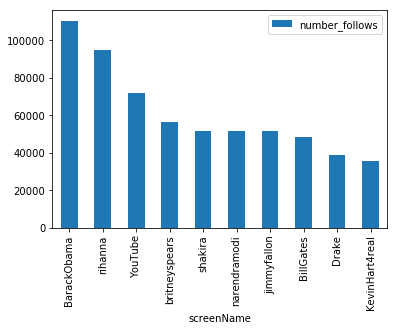

In [55]:
dataset = df_users[['screenName','number_follows']]

dataset['number_follows']=dataset['number_follows']/1000

dataset.set_index("screenName", inplace = True)
dataset.plot.bar()

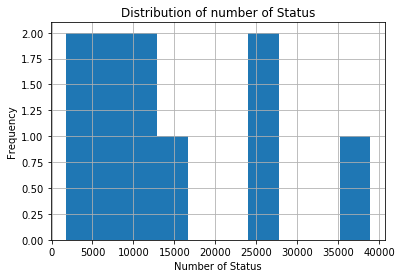

In [62]:
dataset = df_users[['number_status']]



ax=dataset.hist()

plt.title('Distribution of number of Status')
plt.xlabel('Number of Status')
plt.ylabel('Frequency')
plt.show()

In [10]:
def search_github(keywords):
    query = '+'.join(keywords) + '+in:readme+in:description'
    result = g.search_repositories(query, 'stars', 'desc')
 
    return result.totalCount


In [15]:
mycursor = conn.cursor()
g = Github("8e3268d1acf58d40fd6123475a4cb1dd922acce3")


keywords = ['python','java','mysql','oracle','machine learning','haskel']

for key in keywords:
    mycursor.execute("insert into git_repos values ('" + key + "','" + str(search_github(key)) + "')")  

conn.commit()

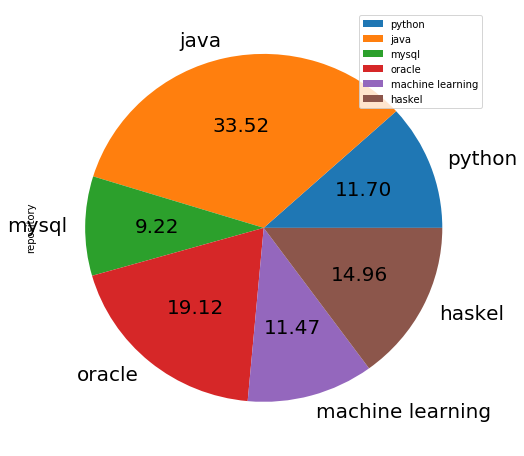

In [32]:
sql_query="select * from git_repos"

df_git = pd.read_sql_query(sql_query, conn)



df_git['repository']=df_git['repository'].astype('int')

df_git.set_index("key", inplace = True)

df_git.plot(kind='pie', y='repository',subplots=True, figsize=(8, 8),autopct='%.2f',fontsize=20)

plt.legend(loc=0, fontsize=10)